# 溯源估计

In [1]:
%matplotlib qt

In [2]:
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import mne_bids
import mne

matplotlib.use('Qt5Agg')
mne.set_log_level('WARNING')

## 从一些新的分段开始

In [ ]:
sample_data_dir = 'F:/Database/Multimodal_data/mne_data/MNE-sample-data/' # 设置已有数据路径
sample_data_dir = pathlib.Path(sample_data_dir)
bids_root = pathlib.Path(sample_data_dir / 'out_data/sample_BIDS')

bids_path = mne_bids.BIDSPath(subject='01',
                              session='01',
                              task='audiovisual',
                              run='01',
                              datatype='meg',
                              root=bids_root)

raw = mne_bids.read_raw_bids(bids_path)
raw.load_data()
raw.filter(l_freq=0.1, h_freq=40)
events, event_id = mne.events_from_annotations(raw)

tmin = -0.2
tmax = 0.5
baseline = (None, 0)

epochs = mne.Epochs(raw, 
                    events=events,
                    event_id=event_id,
                    tmin=tmin, 
                    tmax=tmax,
                    baseline=baseline,
                    preload=True,
                    proj=False)
epochs.save(pathlib.Path(sample_data_dir / 'out_data') / 'epochs_for_source_epo.fif')
epochs.info

Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,mne_anonymize
Participant,sub-01
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus, 59 EEG, 1 EOG"
Bad channels,"MEG 2443, EEG 053"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,40.00 Hz


## 查看BEM

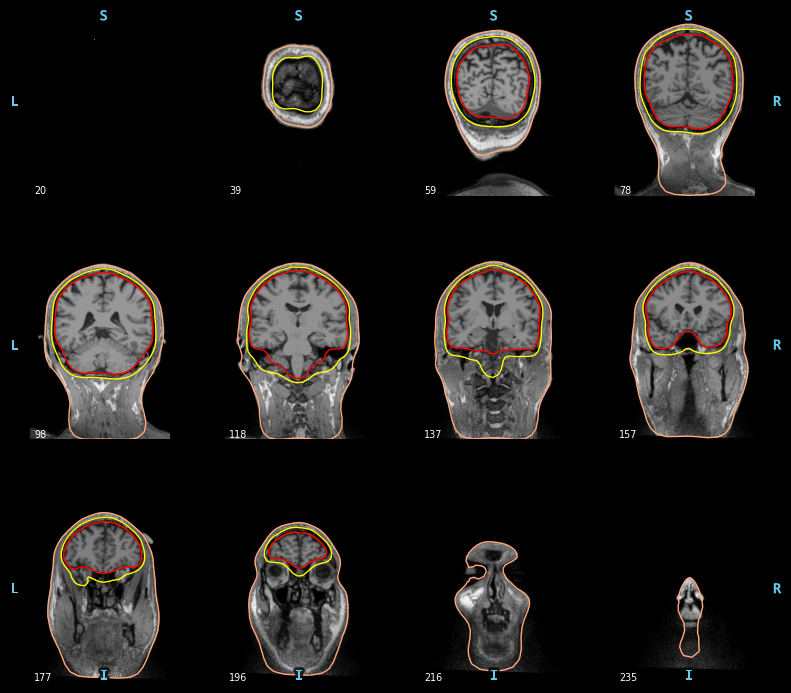

In [4]:
subjects_dir = pathlib.Path(sample_data_dir / 'subjects')

mne.viz.plot_bem(subject='sample', subjects_dir=subjects_dir, orientation='coronal')

## 将MRI与受试者的头部形状进行配准，可视化界面进行

In [9]:
epochs_fname = pathlib.Path(sample_data_dir / 'out_data') / 'epochs_for_source_epo.fif'

mne.gui.coregistration(subject='sample', subjects_dir=subjects_dir, inst=epochs_fname)

d:\Miniconda3\envs\MF\lib\site-packages\ipykernel\eventloops.py:145: RuntimeWarning: This filename (F:/Database/Multimodal_data/mne_data/MNE-sample-data/out_data/sample) does not conform to MNE naming conventions. All trans files should end with -trans.fif, -trans.fif.gz, _trans.fif or _trans.fif.gz
  el.exec() if hasattr(el, "exec") else el.exec_()


在这步要完成配准并保存配准文件'sample_trans.fif'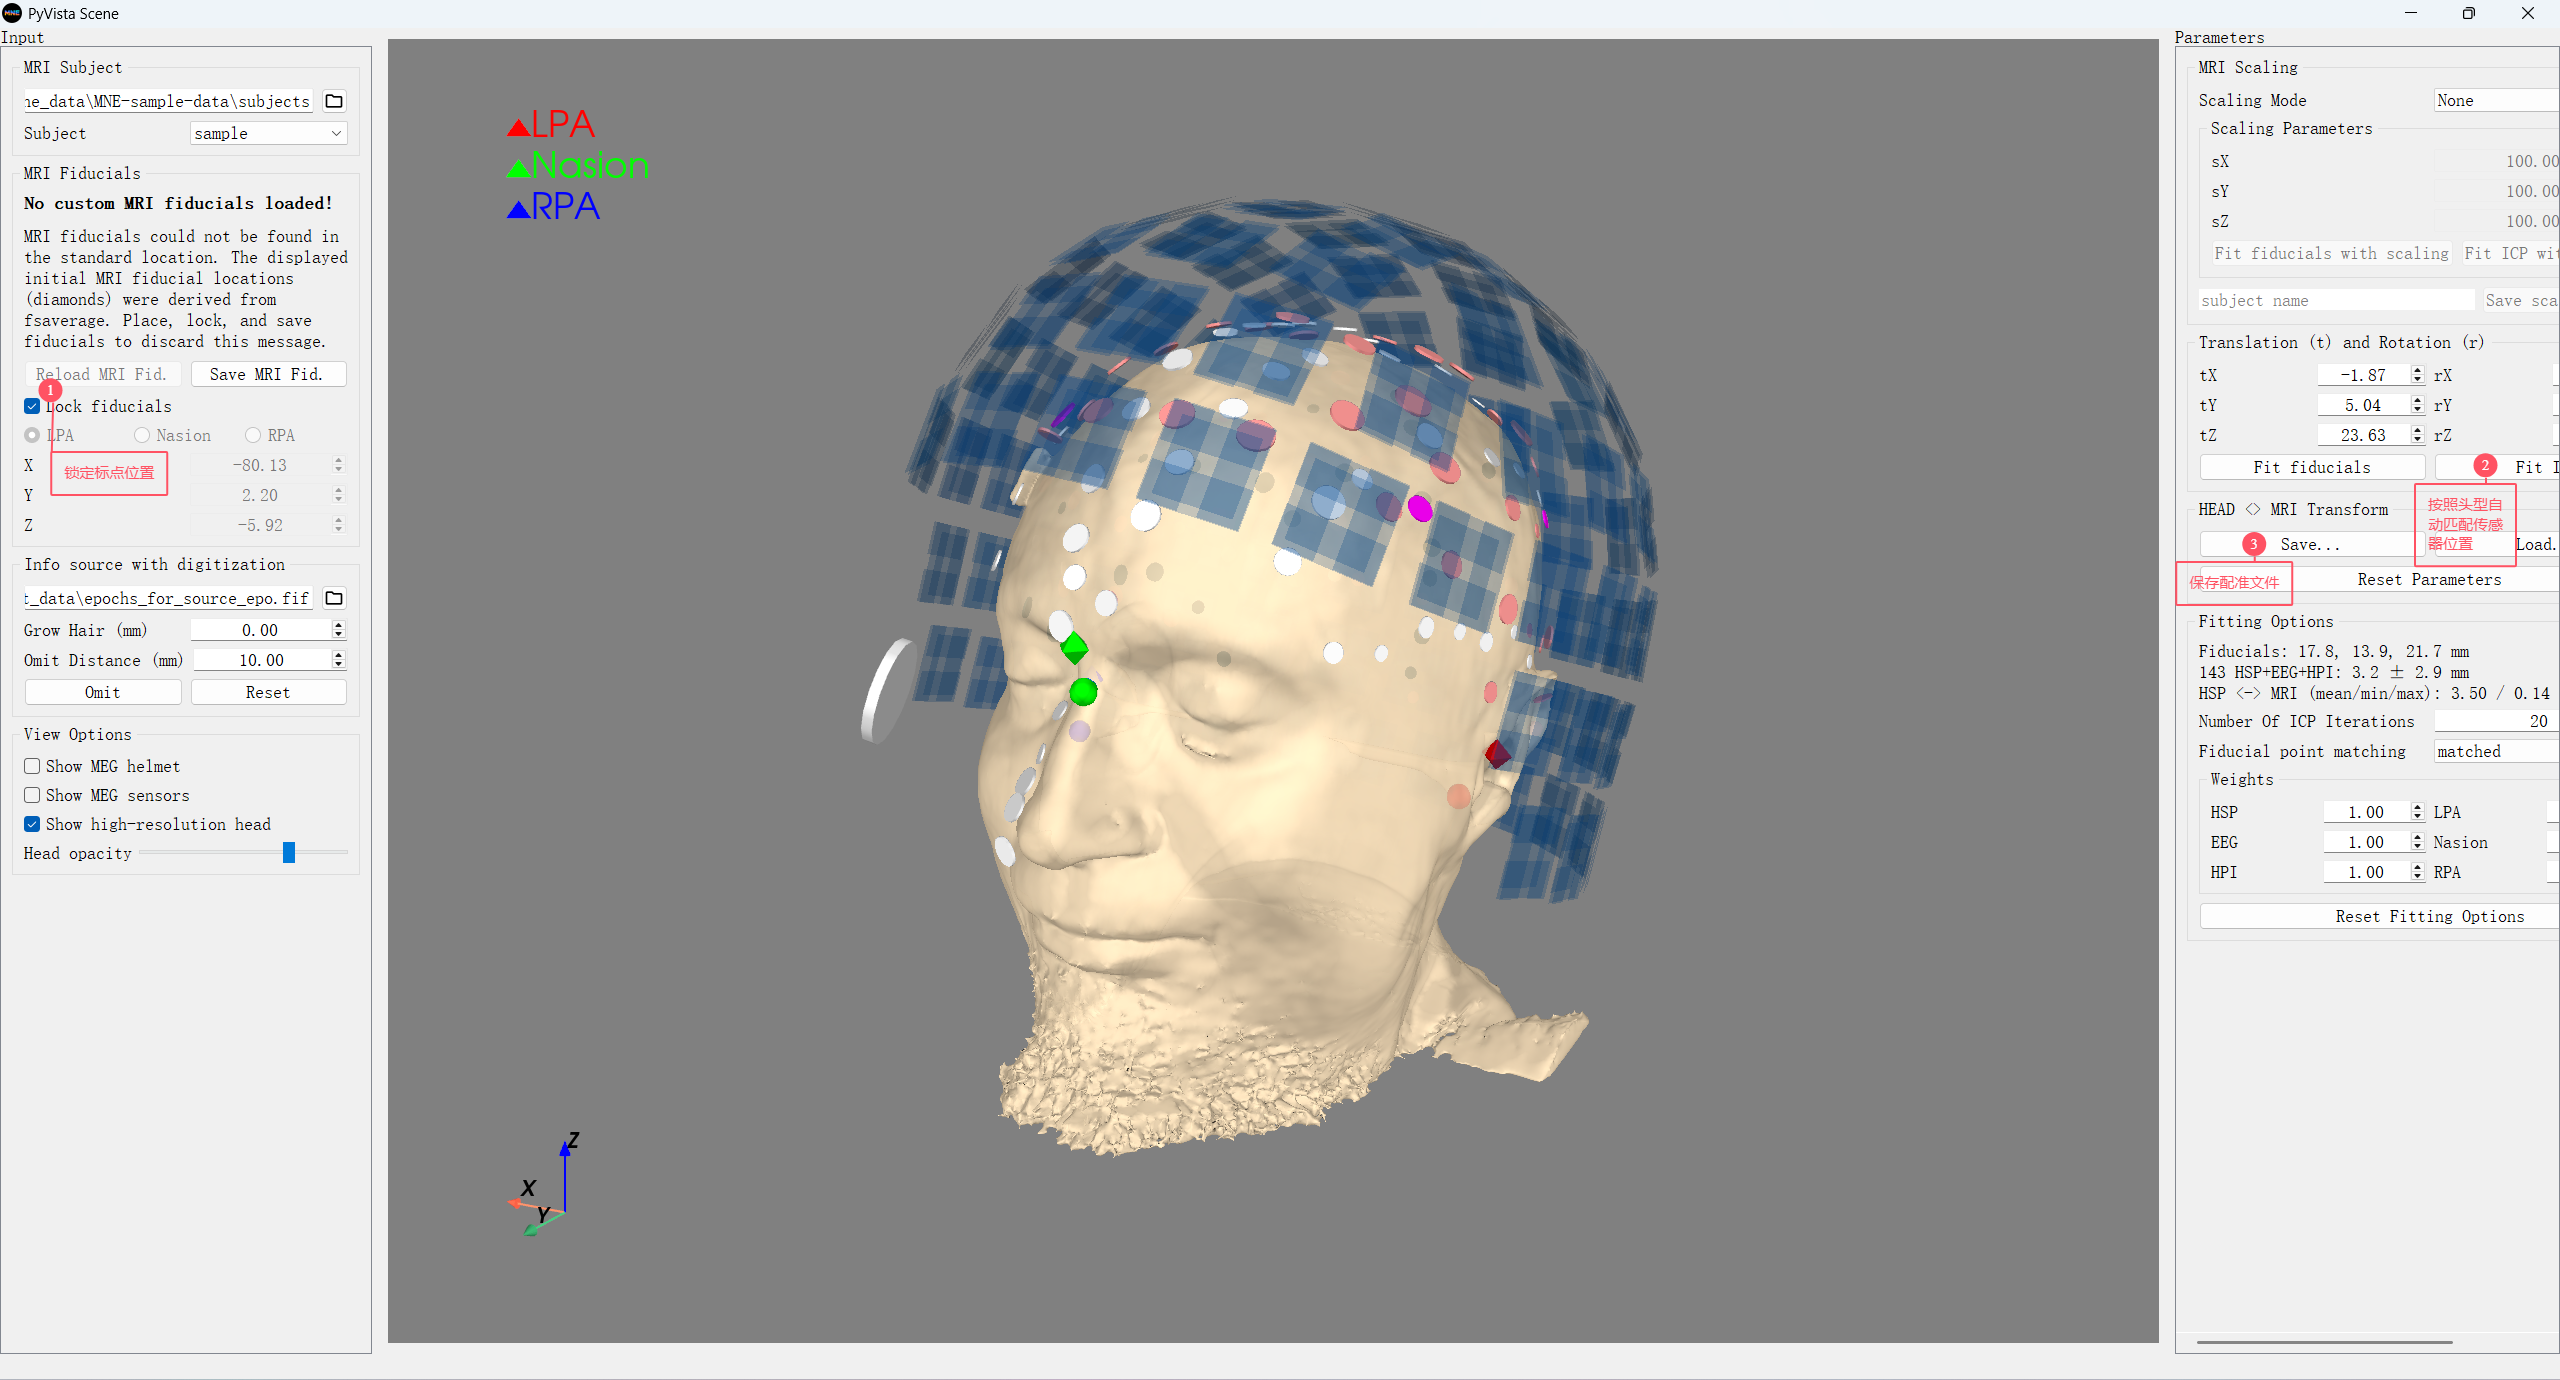

In [13]:
trans_fname = pathlib.Path(sample_data_dir / 'out_data') / 'sample_trans.fif'
info = mne.io.read_info(epochs_fname)
fig = mne.viz.plot_alignment(info=info, trans=trans_fname, subject='sample', dig=True, subjects_dir=subjects_dir, verbose=True)

Using outer_skin.surf for head surface.
Getting helmet for system 306m
Channel types::	grad: 203, mag: 102, eeg: 59


## 计算源空间

In [ ]:
subject = 'sample'
src = mne.setup_source_space(subject=subject,
                             spacing='oct4', # 设置源空间，在实际分析时使用'oct6'
                             subjects_dir=subjects_dir,
                             add_dist=False # 实际分析时删除此行
) 
src

<SourceSpaces: [<surface (lh), n_vertices=155407, n_used=258>, <surface (rh), n_vertices=156866, n_used=258>] MRI (surface RAS) coords, subject 'sample', ~22.7 MB>

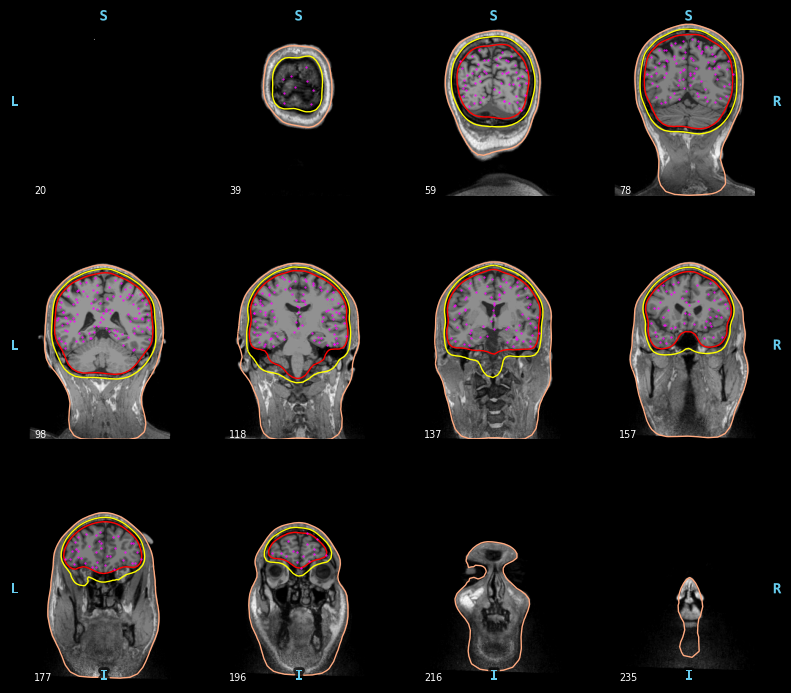

In [ ]:
mne.viz.plot_bem(src=src, subjects_dir=subjects_dir, subject='sample') # 源在 BEM 表面上方用紫色可视化

In [30]:
mne.viz.plot_alignment(info=info, trans=trans_fname, subject=subject,
                       src=src, subjects_dir=subjects_dir, dig=True,
                       surfaces=['head-dense', 'white'], coord_frame='meg')
# 可在3D大脑结构中查看所有源

## 计算正向解

In [17]:
conductivity = (0.3,) # 单层，用于MEG
# conductivity = (0.3, 0.006, 0.3) # 三层，用于EEG
model = mne.make_bem_model(subject=subject, #此函数用于创建一个边界元模型（BEM）
                            ico=4, # 设置ico参数为4，表示使用四阶细分的球形模型
                            conductivity=conductivity, # conductivity参数指定组织的导电率
                            subjects_dir=subjects_dir)
model

[{'id': 1 (FIFFV_BEM_SURF_ID_BRAIN),
  'sigma': 0.3,
  'np': 2562,
  'ntri': 5120,
  'coord_frame': 5,
  'rr': array([[ 0.0006128, -0.007984 ,  0.103732 ],
         [ 0.0568749, -0.0089022,  0.073789 ],
         [ 0.0235464,  0.0574384,  0.0829638],
         ...,
         [ 0.007272 ,  0.0033751, -0.0268523],
         [ 0.0017443,  0.0061639, -0.0268488],
         [ 0.0038775,  0.003904 , -0.0327116]]),
  'nn': array([[-1.41976393e-05,  1.38905590e-18,  1.00000000e+00],
         [ 8.94547443e-01,  0.00000000e+00,  4.46973010e-01],
         [ 2.76442723e-01,  8.50701266e-01,  4.47086991e-01],
         ...,
         [ 9.06305003e-02,  1.47212416e-01, -9.84943966e-01],
         [ 1.32152692e-02,  1.72348009e-01, -9.84947471e-01],
         [ 3.46996163e-02,  1.06791635e-01, -9.93675744e-01]]),
  'tris': array([[   0,  644,  642],
         [ 642,  643,  162],
         [ 644,  643,  642],
         ...,
         [2561, 2201,  557],
         [2477, 2201, 2561],
         [2477,   11, 2201]])}]

In [18]:
bem_sol = mne.make_bem_solution(model) # 使用线性配置方法创建边界元解
bem_sol

<ConductorModel | BEM (1 layer) solver=mne>

In [19]:
bem_fname = pathlib.Path(sample_data_dir / 'out_data') / 'sample_bem.fif'
mne.bem.write_bem_solution(bem_fname, bem_sol) # 保存 bem_sol

In [ ]:
raw_fname = pathlib.Path(sample_data_dir / 'out_data') / 'epochs_for_source_epo.fif'
fwd = mne.make_forward_solution(raw_fname, # raw文件路径
                                trans=trans_fname, # trans文件
                                src=src, # 源点位置
                                bem=bem_sol, # bem方法
                                meg=True, # 包含MEG通道
                                eeg=False, # 排除EEG通道
                                mindist=5.0, # 忽略小于5mm的源点
                                n_jobs=1) # 并行计算数量
fwd
# 示例代码：https://mne.tools/stable/auto_tutorials/forward/30_forward.html#sphx-glr-auto-tutorials-forward-30-forward-py

Good channels,"203 Gradiometers, 102 Magnetometers"
Bad channels,MEG 2443
Source space,Surface with 474 vertices
Source orientation,Free


In [32]:
fwd_fname = pathlib.Path(sample_data_dir / 'out_data') / 'sample_fwd.fif'
mne.write_forward_solution(fwd_fname, fwd, overwrite=True)

## 计算噪声协方差

In [33]:
noise_cov = mne.compute_covariance(epochs, tmax=0., method=['shrunk', 'empirical'], rank='info')
mne.viz.plot_cov(noise_cov, info=info)

C:\Users\pomelo\AppData\Local\Temp\ipykernel_28072\2870909501.py:1: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  noise_cov = mne.compute_covariance(epochs, tmax=0., method=['shrunk', 'empirical'], rank='info')


(<Figure size 1139x370 with 6 Axes>, <Figure size 1139x370 with 3 Axes>)

In [ ]:
# contrast.plot_white(noise_cov) # 这个'contrast'变量未知

## 创建逆运算符

In [36]:
from mne.forward import read_forward_solution
from mne.minimum_norm import (make_inverse_operator, apply_inverse, write_inverse_operator)

In [42]:
fwd_fname = pathlib.Path(sample_data_dir / 'out_data') / 'sample_fwd.fif'
fwd = mne.read_forward_solution(fwd_fname)
fwd = mne.convert_forward_solution(fwd, surf_ori=True)

# 根据需要限制MEG的正向解
fwd = mne.pick_types_forward(fwd, meg=True, eeg=False)

# 创建一个M/EEG、MEG-only和EEG-only的逆操作
# info = contrast.info
inverse_operator = make_inverse_operator(info, fwd, noise_cov, loose=0.2, depth=0.8)

## 应用逆运算符->计算源估计

In [ ]:
evoked = epochs['Auditory/Left'].average()
method = 'dSPM'
snr = 3.
lambda2 = 1. / snr ** 2
stc = apply_inverse(evoked, inverse_operator, lambda2, method=method, pick_ori=None) # 对诱发数据应用逆运算

## 结果展示

In [45]:
brain = stc.plot(surface='inflated',
                 hemi='both',
                 subjects_dir=subjects_dir,
                 time_viewer=True)